# Notebook for Developing Experiments on CovType Data Set

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

**NEED TO**
 - Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [3]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [17]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# model = RandomForestClassifier(random_state=42)
param_grid = {"clf__n_estimators": [3, 5], "clf__max_depth": [3, 5]}

<IPython.core.display.Javascript object>

In [18]:
17500 * 2

35000

<IPython.core.display.Javascript object>

### Run

In [19]:
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
topline.run()

uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2.run()

margin_threshold = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold.run()

Dataset index of split end: 70000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.06082224396406262, 0.9553130970093671), mean=0.5716339437376017, variance=0.045253980515958886, skewness=-0.2552568871807126, kurtosis=-1.4490532006120391)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.08380784874654466, 0.9374886530743936), mean=0.568570930807092, variance=0.052560522580864834, skewness=-0.27735415036599026, kurtosis=-1.4736223256533512)
KS Test Result: FAILED | KstestResult(statistic=0.06925714285714286, pvalue=1.9719804268224e-73)

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.0816121163559665, 0.9527778656011489), mean=0.5692658375591632, variance=0.04

KS Test Result: FAILED | KstestResult(statistic=0.1879428571428572, pvalue=0.0)

Dataset index of split end: 490000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 12
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Dataset Split: 13
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.09476104096399661, 0.963882928821733), mean=0.5754271480395319, variance=0.031008671891587222, skewness=-0.2646037321876836, kurtosis=-1.2696319054127094)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.14310507167828238, 0.9299660720434686), mean=0.5739266776535201, variance=0.022453301899158902, skewness=-0.4266950815127941, kurtosis=-0.8152957912230381)
KS Test Result: FAILED | KstestResult(statistic=0.14125714285714286, pvalue=4.01638082377747e-305)

Dataset index of split end: 70000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
X2 Test Result: 

<IPython.core.display.Javascript object>

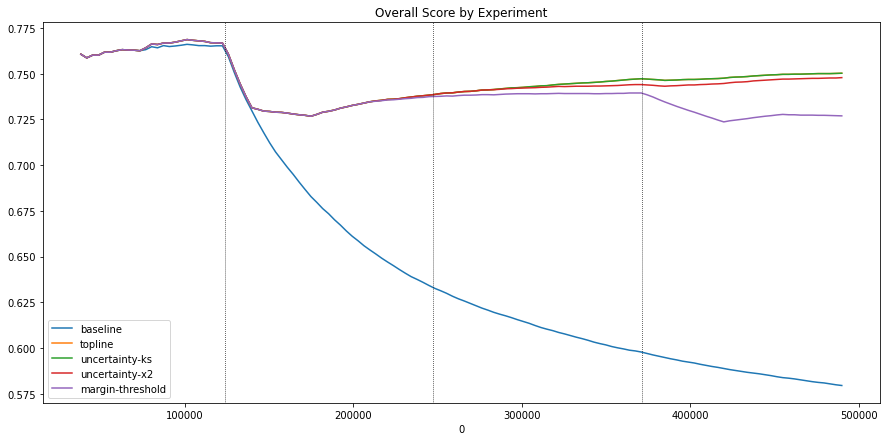

,times_retrained,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,
baseline,1,0.0707,0.5795,0.11
topline,14,0.9896,0.7502,1.44
uncertainty-ks,14,0.9896,0.7502,1.50
uncertainty-x2,11,0.7776,0.7478,1.14
margin-threshold,6,0.4241,0.7269,0.66


<IPython.core.display.Javascript object>

In [20]:
exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Experiment with Window Sizes

In [4]:
multiple_exp_log = []
for multiple in [1, 2, 3, 4]:

    column_mapping = {
        "target": "cover_type",
        "numerical_features": [col for col, iscat in col_names if not iscat],
        "categorical_features": [col for col, iscat in col_names if iscat][:-1],
    }

    # 17500
    CT_dataset = Dataset(
        full_df=drift_df, column_mapping=column_mapping, window_size=17500 * multiple
    )

    model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
    param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

    baseline = BaselineExperiment(
        model=model, dataset=CT_dataset, param_grid=param_grid
    )
    baseline.run()

    topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
    topline.run()

    uncertainty_ks = UncertaintyKSExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
    )
    uncertainty_ks.run()

    uncertainty_x2 = UncertaintyX2Experiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        significance_thresh=0.001,
        margin_width=0.1,
    )
    uncertainty_x2.run()

    margin_threshold = MarginThresholdExperiment(
        model=model,
        dataset=CT_dataset,
        param_grid=param_grid,
        k=10,
        margin_width=0.1,
        sensitivity=1,
    )
    margin_threshold.run()

    exps = [baseline, topline, uncertainty_ks, uncertainty_x2, margin_threshold]
    multiple_exp_log.append(exps)
#     plot_multiple_experiments(exps, change_points)
#     aggregate_experiment_metrics(exps)

Dataset index of split end: 35000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.06003503343249515, 0.9842420126059552), mean=0.5729656983258843, variance=0.043346283743473116, skewness=-0.2565877812933201, kurtosis=-1.3752873655103182)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.07304140393092884, 0.9182203475488329), mean=0.5740458958242889, variance=0.048422435996432214, skewness=-0.34174117571053947, kurtosis=-1.3995605646341984)
KS Test Result: FAILED | KstestResult(statistic=0.05217142857142856, pvalue=3.866956525466162e-21)

Dataset index of split end: 52500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.048993199328387645, 0.9409266936176266), mean=0.571970416500205, variance=0

KS Test Result: FAILED | KstestResult(statistic=0.0446857142857143, pvalue=1.2753896324102675e-15)

Dataset index of split end: 245000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 12
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Dataset Split: 13
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.05225708451616116, 0.92780311730927), mean=0.5723063082452637, variance=0.028765384951322404, skewness=-0.19434812334996238, kurtosis=-1.1009409558461796)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.06671618526183347, 0.9456035925699122), mean=0.5710634598948576, variance=0.025021415098782508, skewness=-0.2985439962919402, kurtosis=-0.9337344979940809)
KS Test Result: FAILED | KstestResult(statistic=0.06377142857142859, pvalue=2.223662830358711e-31)

Dataset index of split end: 262500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 13
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 14
Dataset Split: 14
REFERENCE STATS: Descri

KS Test Result: FAILED | KstestResult(statistic=0.04125714285714285, pvalue=2.227893320922853e-13)

Dataset index of split end: 455000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 24
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 25
Dataset Split: 25
REFERENCE STATS: DescribeResult(nobs=17500, minmax=(0.09743645056244027, 0.9411239066966995), mean=0.5822253820595414, variance=0.03146854003551733, skewness=-0.30695865863168154, kurtosis=-1.1828663189621913)
DETECTION STATS: DescribeResult(nobs=17500, minmax=(0.125327279308771, 0.9504006897950903), mean=0.5804304150453218, variance=0.039564366985006906, skewness=-0.09509262214575473, kurtosis=-1.540316405541111)
KS Test Result: FAILED | KstestResult(statistic=0.11565714285714279, pvalue=2.002643280657374e-102)

Dataset index of split end: 472500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 25
FINAL SHAPE kfold preds: (17500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 26
Dataset Split: 26
REFERENCE STATS: Descri

GETTING DETECTION DISTRIBUTION FOR WINDOW: 21
X2 Test Result: FAILED | Power_divergenceResult(statistic=493.32882651693313, pvalue=2.6884523122003547e-109)

Dataset index of split end: 402500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 18
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 22
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.36949100825752806, pvalue=0.5432818430235901)

Dataset index of split end: 420000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 23
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.7259574776982762, pvalue=0.18892798942587713)

Dataset index of split end: 437500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 24
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.9612149018145891, pvalue=0.32688097386078996)

Dataset index of split end: 455000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 25
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.28029026536


Dataset index of split end: 472500
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 7
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 26
Significant Change in Margin Density: True
Change in MD: 0.06851428571428575
Sensitivity: 1 | Ref_SD: 0.04947277956985384 | Threshold: 0.04947277956985384

Dataset index of split end: 490000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 8
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 27
Significant Change in Margin Density: False
Change in MD: 0.004342857142857148
Sensitivity: 1 | Ref_SD: 0.03703990126491006 | Threshold: 0.03703990126491006

Dataset index of split end: 70000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.06082224396406262, 0.9553130970093671), me

KS Test Result: FAILED | KstestResult(statistic=0.04354285714285715, pvalue=2.8651212063397827e-29)

Dataset index of split end: 455000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 11
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
Dataset Split: 12
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.021996802469816418, 0.977384453054729), mean=0.5738527267896335, variance=0.03141586080798881, skewness=-0.3004841528614454, kurtosis=-1.2340399092577734)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.02489931295901445, 0.9338983983965031), mean=0.5729530208979096, variance=0.04459886906734567, skewness=-0.2223997790712034, kurtosis=-1.5926423656173145)
KS Test Result: FAILED | KstestResult(statistic=0.1879428571428572, pvalue=0.0)

Dataset index of split end: 490000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 12
FINAL SHAPE kfold preds: (35000,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Dataset Split: 13
REFERENCE STATS: DescribeResult(nobs=35000

GETTING DETECTION DISTRIBUTION FOR WINDOW: 11
Significant Change in Margin Density: True
Change in MD: 0.04685714285714285
Sensitivity: 1 | Ref_SD: 0.037424383626132283 | Threshold: 0.037424383626132283

Dataset index of split end: 455000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 5
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 12
Significant Change in Margin Density: False
Change in MD: 0.011657142857142866
Sensitivity: 1 | Ref_SD: 0.03696882304795515 | Threshold: 0.03696882304795515

Dataset index of split end: 490000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 13
Significant Change in Margin Density: False
Change in MD: 0.014571428571428569
Sensitivity: 1 | Ref_SD: 0.03696882304795515 | Threshold: 0.03696882304795515

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS:

GETTING REFERENCE DISTRIBUTION FOR WINDOW: 6
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.7051607192031897, pvalue=0.40105503218019933)

Dataset index of split end: 472500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: PASSED | Power_divergenceResult(statistic=4.061725742610372, pvalue=0.043865648454413646)

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Significant Change in Margin Density: False
Change in MD: 0.007561904761904763
Sensitivity: 1 | Ref_SD: 0.012088802187230768 | Threshold: 0.012088802187230768

Dataset index of split end: 157500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Significant Change in Margin Density: True
Change in MD: 0.029695238095238094
Sensitivity

GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
X2 Test Result: PASSED | Power_divergenceResult(statistic=2.5950771713911025, pvalue=0.10719621808174828)

Dataset index of split end: 420000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
X2 Test Result: FAILED | Power_divergenceResult(statistic=727.9334976197681, pvalue=2.520861740727632e-160)

Dataset index of split end: 490000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 4
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
X2 Test Result: FAILED | Power_divergenceResult(statistic=71.15160870904096, pvalue=3.308029017306476e-17)

Dataset index of split end: 140000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Significant Change in Margin Density: False
Change in MD: 0.006771428571428574
Sensitivity: 1 | Ref_SD: 0.008462835921647937 | Threshold: 0

<IPython.core.display.Javascript object>

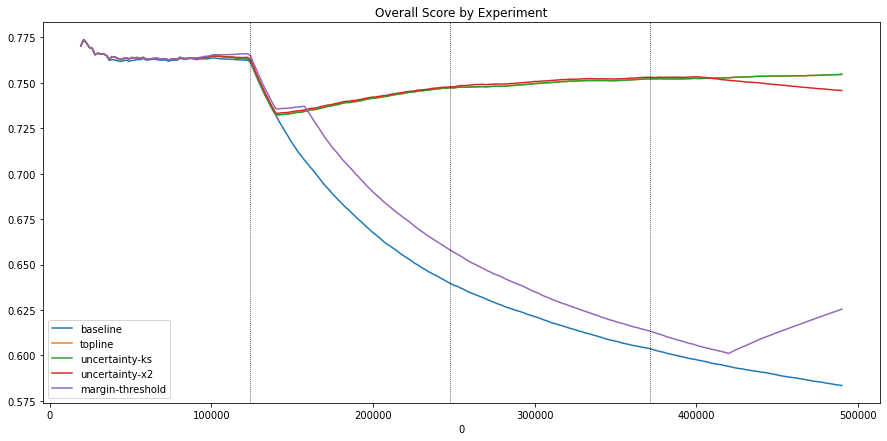

                  times_retrained  percent_total_labels  cumulative_accuracy
experiment                                                                  
baseline                        1                0.0353               0.5835
topline                        28                0.9896               0.7546
uncertainty-ks                 28                0.9896               0.7546
uncertainty-x2                 19                0.6715               0.7457
margin-threshold                9                0.3181               0.6255


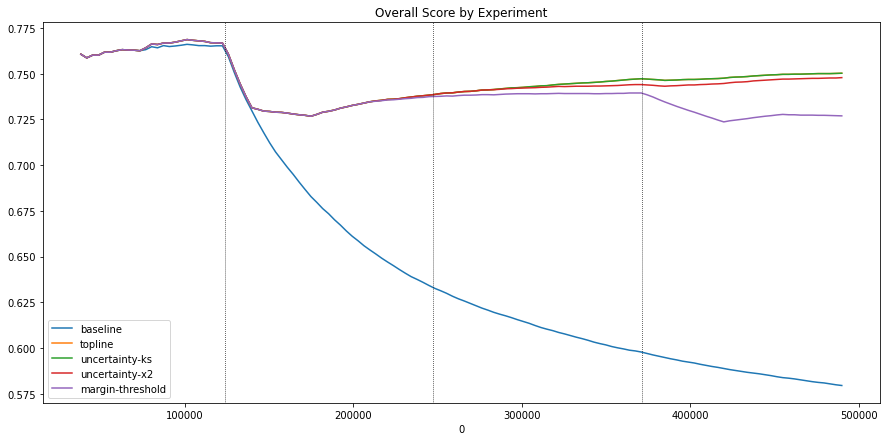

                  times_retrained  percent_total_labels  cumulative_accuracy
experiment                                                                  
baseline                        1                0.0707               0.5795
topline                        14                0.9896               0.7502
uncertainty-ks                 14                0.9896               0.7502
uncertainty-x2                 11                0.7776               0.7478
margin-threshold                6                0.4241               0.7269


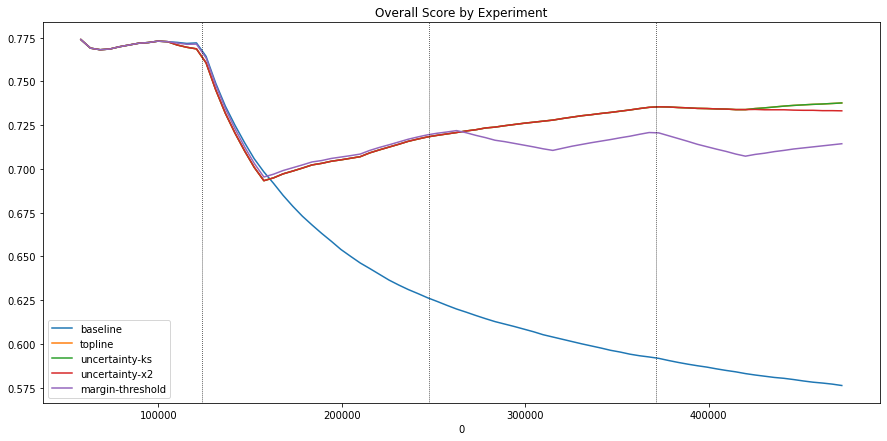

                  times_retrained  percent_total_labels  cumulative_accuracy
experiment                                                                  
baseline                        1                0.1060               0.5763
topline                         9                0.9543               0.7377
uncertainty-ks                  9                0.9543               0.7377
uncertainty-x2                  7                0.7422               0.7332
margin-threshold                6                0.6362               0.7144


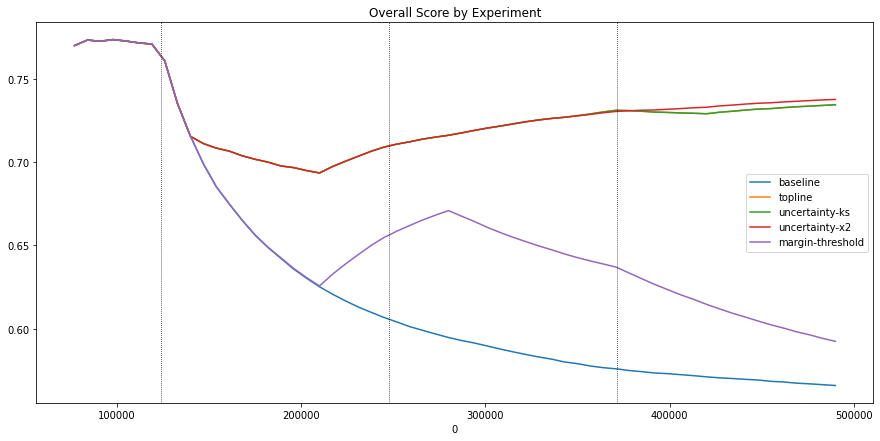

                  times_retrained  percent_total_labels  cumulative_accuracy
experiment                                                                  
baseline                        1                0.1414               0.5660
topline                         7                0.9896               0.7344
uncertainty-ks                  7                0.9896               0.7344
uncertainty-x2                  6                0.8482               0.7376
margin-threshold                2                0.2827               0.5925


<IPython.core.display.Javascript object>

In [16]:
for log in multiple_exp_log:
    plot_multiple_experiments(log, change_points)
    print(aggregate_experiment_metrics(log))

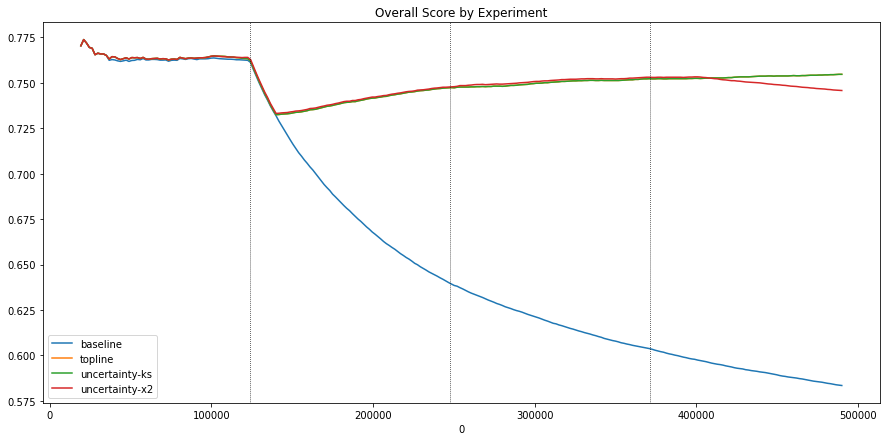

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.0353,0.06
topline,28,0.9896,1.64
uncertainty-ks,28,0.9896,1.65
uncertainty-x2,19,0.6715,1.13


<IPython.core.display.Javascript object>

In [16]:
# window x1
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

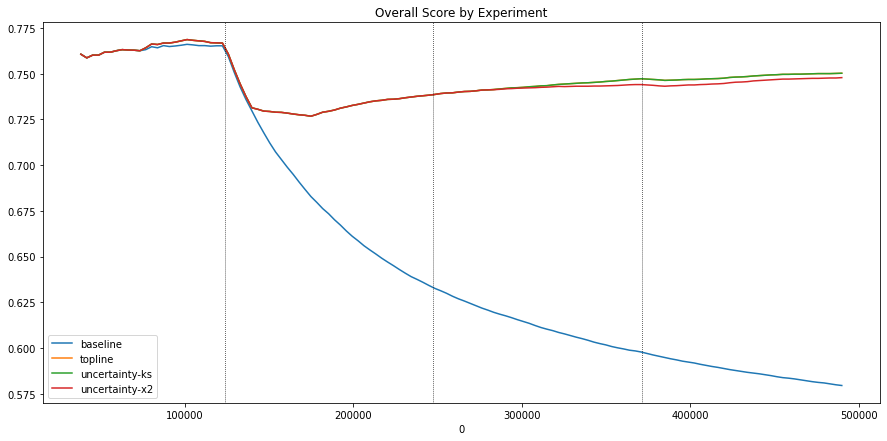

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.0707,0.11
topline,14,0.9896,1.37
uncertainty-ks,14,0.9896,1.36
uncertainty-x2,11,0.7776,1.07


<IPython.core.display.Javascript object>

In [7]:
# window x2
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

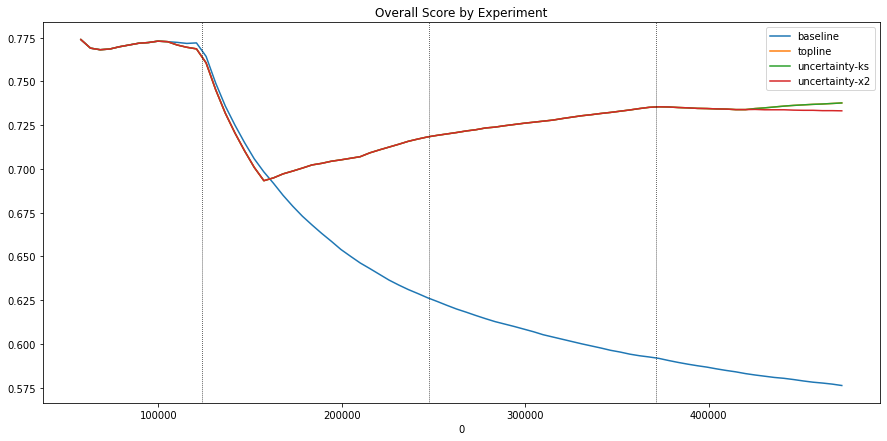

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.1060,0.16
topline,9,0.9543,1.32
uncertainty-ks,9,0.9543,1.36
uncertainty-x2,7,0.7422,1.02


<IPython.core.display.Javascript object>

In [36]:
# window x3
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Uncertainty KS Debug

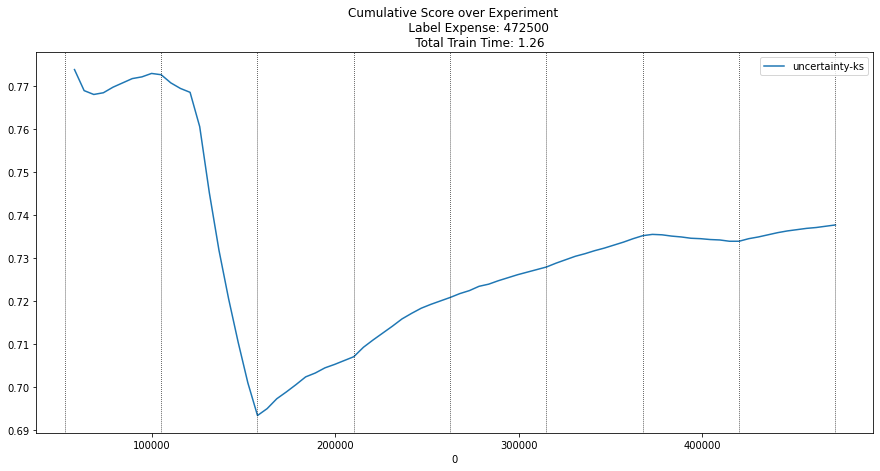

<IPython.core.display.Javascript object>

In [7]:
plot_experiment_error(uncertainty_ks)

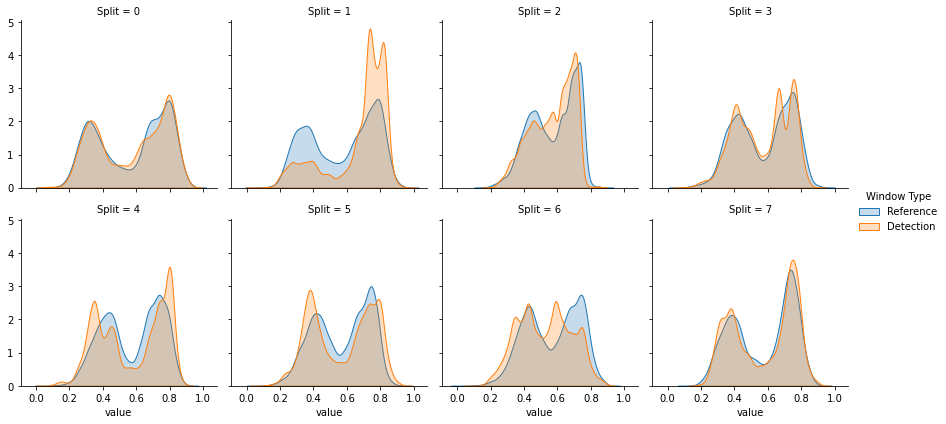

<IPython.core.display.Javascript object>

In [8]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: False
Expected Distribution: [0.9348190476190477, 0.06518095238095238]
Observed Distribution: [0.9423809523809524, 0.05761904761904762]
Percent change in margin: 0.116
Number in Margin: Before 3422 | After 3025 | Difference 397
Chi-Square Results: Power_divergenceResult(statistic=49.2689668557755, pvalue=2.2316513487283537e-12)

Same Distribution: False
Expected Distribution: [0.9196, 0.0804]
Observed Distribution: [0.9524190476190476, 0.047580952380952383]
Percent change in margin: 0.4082
Number in Margin: Before 4221 | After 2498 | Difference 1723
Chi-Square Results: Power_divergenceResult(statistic=764.814723787801, pvalue=2.410953494623594e-168)

Same Distribution: False
Expected Distribution: [0.8010666666666667, 0.19893333333333332]
Observed Distribution: [0.7513333333333333, 0.24866666666666667]
Percent change in margin: 0.25
Number in Margin: Before 10444 | After 13055 | Difference -2611
Chi-Square Results: Power_divergenceResult(statistic=814.8510319573902, 

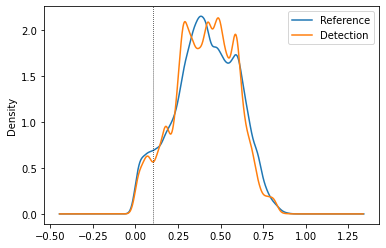

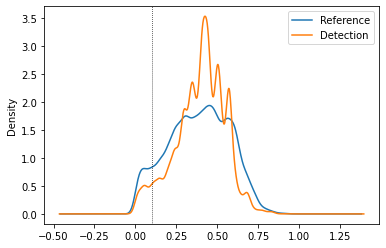

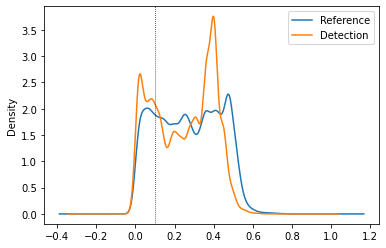

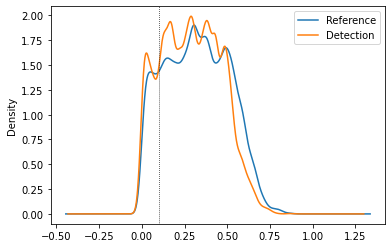

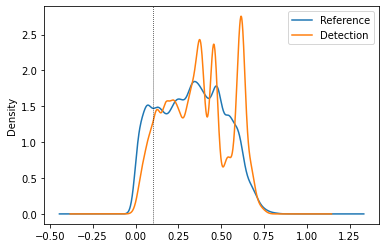

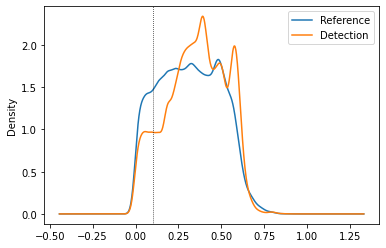

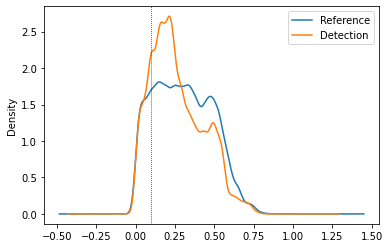

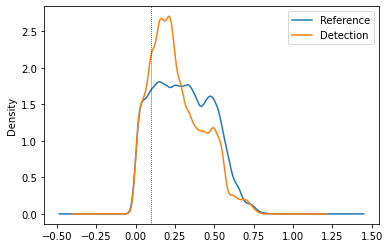

<IPython.core.display.Javascript object>

In [37]:
plot_margin_distributions_bysplit(uncertainty_x2)

## KS Test Deep Dive

### What is minimum reference window size for passing KS test?

Let's see what window size is needed to pass a KS test on the original dataset that has NO drift in it.

In [10]:
with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [11]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

uncertainty_ks_nodrift = UncertaintyKSExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks_nodrift.run()

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
Shape of k-fold preds: (0,)
Shape of k-fold preds: (8750,)
Shape of k-fold preds: (17500,)
Shape of k-fold preds: (26250,)
Shape of k-fold preds: (35000,)
Shape of k-fold preds: (43750,)
Shape of k-fold preds: (52500,)
Shape of k-fold preds: (61250,)
Shape of k-fold preds: (70000,)
Shape of k-fold preds: (78750,)
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.0687480431472266, 0.9661232413232493), mean=0.5716694540600071, variance=0.044276716703953035, skewness=-0.23478936056525296, kurtosis=-1.4388729888553327)
DETECTION STATS: DescribeResult(nobs=87500, minmax=(0.10440688772904749, 0.9429497475121849), mean=0.5733204625044183, variance=0.04164176792823418, skewness=-0.21044955749902566, kurtosis=-1.4150780727217487)
KS Test Result: FAILED | KstestResult(statistic=0.03832000000000002, pvalue=2.95673802022

<IPython.core.display.Javascript object>

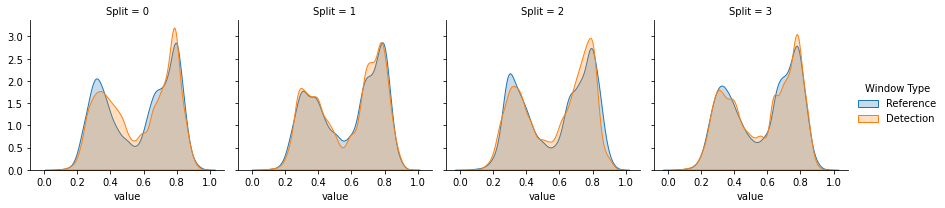

<IPython.core.display.Javascript object>

In [12]:
plot_response_distributions_bysplit(uncertainty_ks_nodrift)

**It looks like Kologorov-Smirnov is too sensitive/strict for our use case**

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

Even with the non-drifting dataset and huge windows, KS tests are too sensitive.

### Distance Metrics instead of KS test?

Maybe we could try calculating a distance instead of applying a check yes-no hypothesis test. The drawback here is that using distances requires us to then tune a threshold that indicates what level of distance is deemed acceptable - another hyperparameter to tune

In [29]:
calculate_split_window_distances(sqsi_mr, scipy.stats.entropy)

,Split,Distance
0,0,0.157516
1,1,0.139466
2,2,0.115135
3,3,0.065857
4,4,0.088850
5,5,0.083910
6,6,0.099678
7,7,0.087009
8,8,0.090778
9,9,0.095081


<IPython.core.display.Javascript object>

In [33]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

,Split,Distance
0,0,0.009110
1,1,0.014873
2,2,0.067819
3,3,0.008488
4,4,0.004169
5,5,0.017748
6,6,0.041464
7,7,0.013371
8,8,0.003046
9,9,0.022570


<IPython.core.display.Javascript object>

In [32]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

,Split,Distance
0,0,0.194725
1,1,0.185078
2,2,0.168608
3,3,0.127677
4,4,0.147346
5,5,0.143425
6,6,0.155732
7,7,0.145795
8,8,0.148882
9,9,0.152298


<IPython.core.display.Javascript object>

## Margin Uncertainty Approach with Chi-Squared Test

In [26]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 3
)

uncertainty_x2_nodrift = UncertaintyX2Experiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2_nodrift.run()

INFO:test_harness.experiments.margin_uncertainty_experiment:-------------------- Started Response Margin Uncertainty Experiment Run --------------------
INFO:test_harness.experiments.baseline_experiment:Trained Model at Index: 0 | GridsearchCV: True
INFO:test_harness.experiments.baseline_experiment:GSCV Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 5}
INFO:test_harness.experiments.baseline_experiment:Train Score: 0.7702904761904763 | GSCV Test Score: 0.7675619047619048
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - True
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 52500
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 52500 - 57750 | 1/10 | 0.7739
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 57750 - 63000 | 2/10 | 0.769


Dataset index of split end: 105000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 63000 - 68250 | 3/10 | 0.7681
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 68250 - 73500 | 4/10 | 0.7685
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 73500 - 78750 | 5/10 | 0.7698
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 78750 - 84000 | 6/10 | 0.7708
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 84000 - 89250 | 7/10 | 0.7718
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 89250 - 94500 | 8/10 | 0.7722
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 94500 - 99750 | 9/10 | 0.773
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 99750 - 105000 | 10/10 | 0.7727


GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0


INFO:test_harness.experiments.margin_uncertainty_experiment:KS Test: Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)


GETTING DETECTION DISTRIBUTION FOR WINDOW: 1


INFO:test_harness.experiments.baseline_experiment:Trained Model at Index: 1 | GridsearchCV: True
INFO:test_harness.experiments.baseline_experiment:GSCV Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 5}
INFO:test_harness.experiments.baseline_experiment:Train Score: 0.7696523809523809 | GSCV Test Score: 0.7680380952380952
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - True
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 105000
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 105000 - 110250 | 1/10 | 0.7708
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 110250 - 115500 | 2/10 | 0.7695


X2 Test Result: FAILED | Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)

Dataset index of split end: 157500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 115500 - 120750 | 3/10 | 0.7686
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 120750 - 126000 | 4/10 | 0.7677
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 126000 - 131250 | 5/10 | 0.7673
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 131250 - 136500 | 6/10 | 0.7665
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 136500 - 141750 | 7/10 | 0.766
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 141750 - 147000 | 8/10 | 0.7653
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 147000 - 152250 | 9/10 | 0.7654
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 152250 - 157500 | 10/10 | 0.7652


GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1


INFO:test_harness.experiments.margin_uncertainty_experiment:KS Test: Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)
INFO:test_harness.experiments.margin_uncertainty_experiment:Need to calculate Reference response distribution? - False
INFO:test_harness.experiments.baseline_experiment:Reference Evaluation at Window Start: 157500
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 157500 - 162750 | 1/10 | 0.7649
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 162750 - 168000 | 2/10 | 0.7649


GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)

Dataset index of split end: 210000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 168000 - 173250 | 3/10 | 0.7648
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 173250 - 178500 | 4/10 | 0.7648
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 178500 - 183750 | 5/10 | 0.765
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 183750 - 189000 | 6/10 | 0.7645
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 189000 - 194250 | 7/10 | 0.7644
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 194250 - 199500 | 8/10 | 0.7643
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 199500 - 204750 | 9/10 | 0.7639
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 204750 - 210000 | 10/10 | 0.7639
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 3
X2 Test Result: PASSED | Power_divergenceResult(statistic=2.374772751367418, pvalue=0.12330954078506305)

Dataset index of split end: 262500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 220500 - 225750 | 3/10 | 0.763
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 225750 - 231000 | 4/10 | 0.7631
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 231000 - 236250 | 5/10 | 0.7631
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 236250 - 241500 | 6/10 | 0.7629
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 241500 - 246750 | 7/10 | 0.7626
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 246750 - 252000 | 8/10 | 0.7625
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 252000 - 257250 | 9/10 | 0.7623
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 257250 - 262500 | 10/10 | 0.7623
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.055454556163297, pvalue=0.3042541895529445)

Dataset index of split end: 315000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 273000 - 278250 | 3/10 | 0.762
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 278250 - 283500 | 4/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 283500 - 288750 | 5/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 288750 - 294000 | 6/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 294000 - 299250 | 7/10 | 0.7615
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 299250 - 304500 | 8/10 | 0.7613
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 304500 - 309750 | 9/10 | 0.7612
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 309750 - 315000 | 10/10 | 0.7612
INFO:test_harness.experiments.margin_uncertainty

GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
X2 Test Result: PASSED | Power_divergenceResult(statistic=7.446932781523263, pvalue=0.006354464416971956)

Dataset index of split end: 367500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 325500 - 330750 | 3/10 | 0.7609
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 330750 - 336000 | 4/10 | 0.7607
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 336000 - 341250 | 5/10 | 0.7606
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 341250 - 346500 | 6/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 346500 - 351750 | 7/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 351750 - 357000 | 8/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 357000 - 362250 | 9/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 362250 - 367500 | 10/10 | 0.7602
INFO:test_harness.experiments.margin_uncertaint

GETTING DETECTION DISTRIBUTION FOR WINDOW: 6
X2 Test Result: PASSED | Power_divergenceResult(statistic=1.8181853877656797, pvalue=0.17752942691639237)

Dataset index of split end: 420000


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 378000 - 383250 | 3/10 | 0.7599
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 383250 - 388500 | 4/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 388500 - 393750 | 5/10 | 0.7597
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 393750 - 399000 | 6/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 399000 - 404250 | 7/10 | 0.7597
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 404250 - 409500 | 8/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 409500 - 414750 | 9/10 | 0.7598
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 414750 - 420000 | 10/10 | 0.76
INFO:test_harness.experiments.margin_uncertainty_

GETTING DETECTION DISTRIBUTION FOR WINDOW: 7
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.35276300961610196, pvalue=0.5525532092335201)

Dataset index of split end: 472500


INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 430500 - 435750 | 3/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 435750 - 441000 | 4/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 441000 - 446250 | 5/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 446250 - 451500 | 6/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 451500 - 456750 | 7/10 | 0.7603
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 456750 - 462000 | 8/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 462000 - 467250 | 9/10 | 0.7602
INFO:test_harness.experiments.baseline_experiment:Evaluated Model at Window Increment: 467250 - 472500 | 10/10 | 0.7603
INFO:test_harness.experiments.margin_uncertaint

GETTING DETECTION DISTRIBUTION FOR WINDOW: 8
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.3720889597411623, pvalue=0.5418678022103016)



<IPython.core.display.Javascript object>

Same Distribution: False
Expected Distribution: [0.9348380952380952, 0.06516190476190477]
Observed Distribution: [0.9312190476190476, 0.06878095238095239]
Percent change in margin: 0.0555
Number in Margin: Before 3421 | After 3611 | Difference -190
Chi-Square Results: Power_divergenceResult(statistic=11.288018847063524, pvalue=0.0007800888138293107)

Same Distribution: True
Expected Distribution: [0.9196190476190477, 0.08038095238095239]
Observed Distribution: [0.9192761904761905, 0.08072380952380952]
Percent change in margin: 0.0043
Number in Margin: Before 4220 | After 4238 | Difference -18
Chi-Square Results: Power_divergenceResult(statistic=0.0834881045402608, pvalue=0.7726249345769923)

Same Distribution: True
Expected Distribution: [0.9196190476190477, 0.08038095238095239]
Observed Distribution: [0.9177904761904762, 0.08220952380952382]
Percent change in margin: 0.0227
Number in Margin: Before 4220 | After 4316 | Difference -96
Chi-Square Results: Power_divergenceResult(statistic

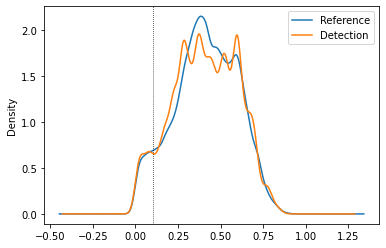

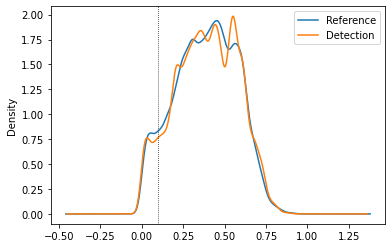

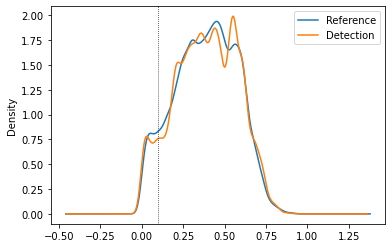

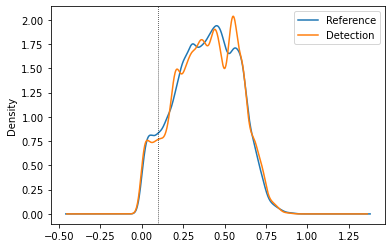

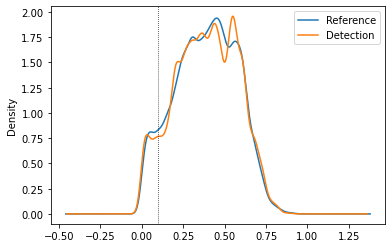

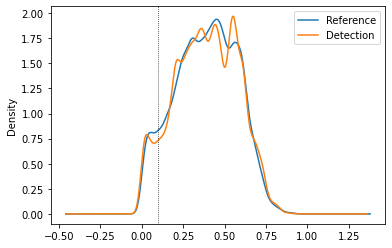

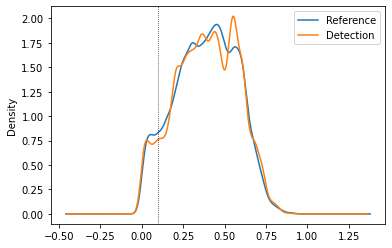

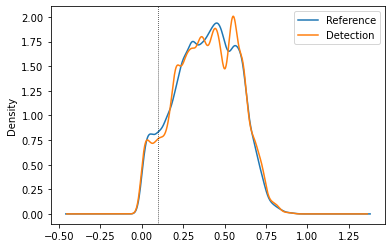

<IPython.core.display.Javascript object>

In [27]:
plot_margin_distributions_bysplit(uncertainty_x2_nodrift)

- Null Hypothesis (H0): Observed data follow the expected distribution
- Alternative Hypothesis (HA): Observed data do NOT follow the expected distribution
    
If p_value is less than 0.05, reject null hypothesis --> They are from different distributions

## Margin Uncertainty Approach with Sensitivity Threshold

In [49]:
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 3
)

margin_threshold_dev = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold_dev.run()

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Significant Change in Margin Density: False
Change in MD: 0.007561904761904763
Sensitivity: 1 | Ref_SD: 0.012088802187230768 | Threshold: 0.012088802187230768

Dataset index of split end: 157500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Significant Change in Margin Density: True
Change in MD: 0.029695238095238094
Sensitivity: 1 | Ref_SD: 0.012088802187230768 | Threshold: 0.012088802187230768

Dataset index of split end: 210000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 1
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=5, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 3
Significant Change in Margin Density: True
Change in MD: 0.012323809523809529
Sensitivity: 1 | Ref_SD: 0.012118073681512541 | Threshold: 0.012118073681512541

Dataset index of split end: 26

<IPython.core.display.Javascript object>

In [44]:
margin_threshold_dev.ref_MDs

[0.06518095238095238,
 0.0804,
 0.19893333333333332,
 0.14398095238095238,
 0.14447619047619048,
 0.14024761904761907,
 0.15700952380952382,
 0.15700952380952382]

<IPython.core.display.Javascript object>

In [46]:
margin_threshold_dev.det_MDs

[0.05761904761904762,
 0.047580952380952383,
 0.24866666666666667,
 0.15826666666666667,
 0.07575238095238095,
 0.09977142857142857,
 0.15834285714285715,
 0.1602095238095238]

<IPython.core.display.Javascript object>

In [45]:
margin_threshold_dev.ref_SDs

[0.012088802187230768,
 0.012118073681512541,
 0.015088840464925184,
 0.04632711845951467,
 0.045708670290028564,
 0.03243503047345662,
 0.03172810223847825,
 0.03172810223847825]

<IPython.core.display.Javascript object>

In [30]:
scipy.stats.describe(margin_threshold_dev.split_MDs)

DescribeResult(nobs=10, minmax=(0.10114285714285715, 0.20714285714285716), mean=0.14368571428571428, variance=0.0013466385487528347, skewness=0.2247591984684038, kurtosis=-1.1535971832623375)

<IPython.core.display.Javascript object>

In [31]:
np.mean(margin_threshold_dev.split_MDs)

0.14368571428571428

<IPython.core.display.Javascript object>

In [32]:
np.std(margin_threshold_dev.split_MDs)

0.03481342691947392

<IPython.core.display.Javascript object>

In [18]:
margin_threshold_dev.ref_margins[0]

array([0.67820893, 0.36434785, 0.31751187, ..., 0.41590601, 0.39750489,
       0.45846928])

<IPython.core.display.Javascript object>

In [25]:
pd.Series(
    margin_threshold_dev.ref_margins[0] < margin_threshold_dev.margin_width
).astype(int).value_counts(normalize=True)[1]

0.0664

<IPython.core.display.Javascript object>